# **Specific Test V. Physics-Guided ML**

1. Imports essential libraries for deep learning (torch, torchvision), data handling (numpy, PIL, os, glob), and evaluation (sklearn.metrics).

2. Uses torchvision.transforms for image preprocessing.

3. Handles datasets with Dataset, DataLoader, and Subset.

4. Loads a pretrained model from torchvision.models.

5. Evaluates performance using roc_auc_score and roc_curve.

6. Manages files and directories with os and glob.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models
from sklearn.metrics import roc_auc_score, roc_curve
import os
from glob import glob
from PIL import Image
from collections import Counter


* Checks for GPU availability and sets device to "cuda" if available, otherwise "cpu".

* Defines dataset paths for training and validation images, categorized into **three classes: "no", "vort", and "sphere".**

* Creates a label mapping assigning integer labels: **"no" → 0, "vort" → 1, "sphere" → 2.**

In [ ]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset paths
train_dirs = {"no": "dataset/dataset/train/no/", "vort": "dataset/dataset/train/vort/", "sphere": "dataset/dataset/train/sphere/"}
valid_dirs = {"no": "dataset/dataset/val/no/", "vort": "dataset/dataset/val/vort/", "sphere": "dataset/dataset/val/sphere/"}

# Label mapping
label_map = {"no": 0, "vort": 1, "sphere": 2}

1. **Custom Dataset (LensingDataset)**

> * Inherits from torch.utils.data.Dataset.
>* Loads .npy image files and their corresponding labels from specified directories.
>* Converts images to float32 and ensures a consistent shape (H, W).
>* Applies optional transformations during data retrieval.

2. **Data Normalization (compute_mean_std)**

>* Computes the mean and standard deviation of all .npy images in the training dataset.
>* Uses numpy operations to standardize pixel values (/ 255.0).

3. **Data Transformations (transforms.Compose)**

>* Converts numpy arrays to PIL.Image.
>* Applies random augmentations:
>>* Affine transformations (rotation ±15°, translation, scaling).
>>* Random horizontal flipping.
>>* Random resized cropping (target size: 128×128).
>>* Gaussian blur (3×3 kernel).
>* Converts images to PyTorch tensors and normalizes them using computed mean and standard deviation.

In [ ]:
# Custom Dataset Class
class LensingDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        for label, path in directories.items():
            npy_files = glob(os.path.join(path, "*.npy"))
            if len(npy_files) == 0:
                print(f"Warning: No .npy files found in {path}")
            for img_path in npy_files:
                self.data.append(img_path)
                self.labels.append(label_map[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.load(self.data[idx]).astype(np.float32)  
        image = image.squeeze()  # Ensure shape is (H, W)

        label = self.labels[idx]  # Scalar class label

        if self.transform:
            image = self.transform(image)  # Convert to tensor (C, H, W)

        return image, label

# Compute mean and std for normalization
def compute_mean_std(dataset_dirs):
    all_data = []
    for label, path in dataset_dirs.items():
        npy_files = glob(os.path.join(path, "*.npy"))
        for img_path in npy_files:
            img = np.load(img_path).astype(np.float32)
            all_data.append(img)

    all_data = np.stack(all_data)  # Convert list to numpy array
    mean = np.mean(all_data) / 255.0
    std = np.std(all_data) / 255.0
    return mean, std

mean, std = compute_mean_std(train_dirs)

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.2)),  # Resize after cropping
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])  # Normalization
])

1. **Loads datasets:** Creates LensingDataset instances for training and validation data with transformations.

2. **Creates a 10% training subset**

* Computes subset size (10% of the full training dataset).

* Randomly selects indices using torch.randperm().

* Constructs a Subset dataset using the selected indices.

3. **Initializes DataLoaders**

* train_loader: Loads the training subset with batch size 32, shuffled.

* valid_loader: Loads the full validation dataset with batch size 32, not shuffled.

4. **Computes and prints class distributions**

* Uses Counter to count label occurrences in:
>* Full training dataset.
>* Full validation dataset.
>* Training subset.










In [ ]:

# Load datasets
train_dataset = LensingDataset(train_dirs, transform=transform)
valid_dataset = LensingDataset(valid_dirs, transform=transform)

# Get 10% of the training dataset
subset_size = int(0.1 * len(train_dataset))
indices = torch.randperm(len(train_dataset))[:subset_size]  
train_subset = Subset(train_dataset, indices)

# Create DataLoader for the subset
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Print label counts
train_label_counts = Counter(train_dataset.labels)
print("Training Set Label Counts:", train_label_counts)
valid_label_counts = Counter(valid_dataset.labels)
print("Validation Set Label Counts:", valid_label_counts)

# Get labels of the subset samples
train_subset_labels = [train_dataset[idx][1] for idx in indices]  
train_subset_label_counts = Counter(train_subset_labels)
print("Training Subset Label Counts:", train_subset_label_counts)

Training Set Label Counts: Counter({0: 10000, 1: 10000, 2: 10000})
Validation Set Label Counts: Counter({0: 2500, 1: 2500, 2: 2500})
Training Subset Label Counts: Counter({2: 1003, 1: 999, 0: 998})


1. **Defines a Physics-Informed ResNet Model (LensingResNet)**

* Uses ResNet-50 as the backbone, loading pretrained weights (IMAGENET1K_V1).

* Modifies the first convolutional layer to accept grayscale images (1-channel).

* Removes the original fully connected (FC) layer (fc = nn.Identity()).

2. **Implements Two Prediction Heads**

* Classification Head (classifier):
>* Fully connected (2048 → 512 → num_classes).
>* Uses ReLU activation and Dropout (0.5).

* Physics-Informed Head (deflection_head):

>* Fully connected (2048 → 512 → 2).
>* Predicts deflection angles and applies tanh activation to normalize output between -1 and 1.

3. **Handles Input Dimensions:** Ensures input has a channel dimension (x.unsqueeze(1)) for single-channel images.

4. **Defines a Physics-Based Loss Function (lensing_loss):**
* Computes predicted source position (β) using the lens equation:

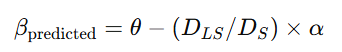

* Uses Smooth L1 Loss (F.smooth_l1_loss) between predicted and actual source positions (β).

In [ ]:

# Define the Physics-Informed ResNet Model
class LensingResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LensingResNet, self).__init__()
        self.base_model = models.resnet50(weights="IMAGENET1K_V1")
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  
        self.base_model.fc = nn.Identity()  

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Physics-informed head for deflection angles
        self.deflection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension if missing
        features = self.base_model(x)
        classification_output = self.classifier(features)
        deflection_output = self.deflection_head(features)
        deflection_output = torch.tanh(deflection_output)  # Normalize between -1 and 1
        return classification_output, deflection_output

# Physics Loss Function
def lensing_loss(deflection_output, theta, beta, D_LS, D_S):
    alpha = deflection_output
    theta = theta.unsqueeze(1).expand(-1, 2)
    beta = beta.unsqueeze(1).expand(-1, 2)
    predicted_beta = theta - (D_LS / D_S) * alpha
    physics_loss = F.smooth_l1_loss(predicted_beta, beta)
    return physics_loss

1. **Model Initialization**: Defines LensingResNet with 3 output classes and moves it to GPU (cuda) if available.

2. **Loss Function & Optimizer**
* Uses CrossEntropyLoss for classification.

* Optimizes with Adam (lr = 0.0001).

3. **Physics Parameters**

* Sets lens-source (D_LS) and source (D_S) distances to 1.0 and 2.0, respectively.

4. **Training Loop (25 epochs)**

> For each epoch:
>* Sets the model to training mode (model.train()).
>* Iterates over mini-batches from train_loader.
>* Ensures grayscale images have a channel dimension (images.unsqueeze(1)).
>* Computes classification loss (CrossEntropyLoss).
>* Computes physics loss (lensing_loss) using a synthetic θ and β.
>* Dynamically adjusts physics loss weight using a sigmoid-based schedule.
>* Performs backpropagation (total_loss.backward()) and updates model parameters.
>* total_loss = class_loss + physics_loss_weight \ physics_loss

5. **Loss Reduction Trend**

* Initial loss: 1.1215 (Epoch 1).

* Gradual decline with training.

* Final loss: 0.6228 (Epoch 25).

* Indicates successful learning and convergence of the model.

In [ ]:

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LensingResNet(num_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Physics parameters
D_LS, D_S = 1.0, 2.0  # Testing values for lensing distances

# Training loop
epochs = 250
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)

        optimizer.zero_grad()

        # Forward pass
        classification_output, deflection_output = model(images)

        # Compute classification loss
        class_loss = criterion(classification_output, labels)

        # Compute physics loss
        batch_size = images.size(0)
        theta = torch.ones(batch_size, device=device) * 0.05
        beta = torch.zeros(batch_size, device=device)
        physics_loss = lensing_loss(deflection_output, theta, beta, D_LS, D_S)

        # Adaptive physics loss weighting
        physics_loss_weight = 0.1 + (0.4 / (1 + torch.exp(-10 * torch.tensor(epoch / epochs - 0.5, device=device))))
        total_loss = class_loss + physics_loss_weight * physics_loss

        # Backpropagation
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/25, Loss: 1.1215
Epoch 2/25, Loss: 1.1094
Epoch 3/25, Loss: 1.1056
Epoch 4/25, Loss: 1.0969
Epoch 5/25, Loss: 1.0977
Epoch 6/25, Loss: 1.0911
Epoch 7/25, Loss: 1.0794
Epoch 8/25, Loss: 1.0545
Epoch 9/25, Loss: 1.0127
Epoch 10/25, Loss: 0.9824
Epoch 11/25, Loss: 0.9347
Epoch 12/25, Loss: 0.9000
Epoch 13/25, Loss: 0.8653
Epoch 14/25, Loss: 0.8433
Epoch 15/25, Loss: 0.8081
Epoch 16/25, Loss: 0.7780
Epoch 17/25, Loss: 0.7423
Epoch 18/25, Loss: 0.7289
Epoch 19/25, Loss: 0.7038
Epoch 20/25, Loss: 0.7031
Epoch 21/25, Loss: 0.6934
Epoch 22/25, Loss: 0.6514
Epoch 23/25, Loss: 0.6398
Epoch 24/25, Loss: 0.6385
Epoch 25/25, Loss: 0.6228


1. **Model Evaluation Mode**

* Sets model.eval() to disable dropout and batch normalization updates.

* Uses torch.no_grad() to prevent gradient computation, reducing memory usage.

2. **Validation Loop**

* Iterates over validation dataset (valid_loader).

* Moves images and labels to GPU (device).

* Ensures grayscale images have the correct shape (images.unsqueeze(1)).

* Performs forward pass to get:

>* Classification output (for label prediction).
>* Deflection output (for physics-based loss).

3. **Loss Computation**

* Classification Loss: CrossEntropyLoss on classification_output.

* Physics-Informed Loss: lensing_loss using synthetic θ and β.

* Total Loss Calculation: total_loss = class_loss + physics_loss_weight \ physics_loss
4. **Final Validation Loss**

* Aggregates total validation loss across all batches.

* Computes average loss over the dataset.

* Final Validation Loss: 0.8567, indicating generalization performance.

In [ ]:
import json

# Validation loop
model.eval()
val_running_loss = 0.0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)

        classification_output, deflection_output = model(images)

        class_loss = criterion(classification_output, labels)

        batch_size = images.size(0)
        theta = torch.ones(batch_size, device=device)
        beta = torch.zeros(batch_size, device=device)
        physics_loss = lensing_loss(deflection_output, theta, beta, D_LS, D_S)

        total_loss = class_loss + physics_loss_weight * physics_loss
        val_running_loss += total_loss.item()

print(f"Final Validation Loss: {val_running_loss/len(valid_loader):.4f}")


Final Validation Loss: 0.8567


**Save model weights to JSON**

In [ ]:


def save_model_weights_json(model, filename="lensing_resnet50_weights.json"):

    # Convert model weights to CPU and list format
    state_dict = {k: v.cpu().tolist() for k, v in model.state_dict().items()}

    # Save to JSON file
    with open(filename, "w") as f:
        json.dump(state_dict, f)

    print(f"Model weights saved to {filename}")

# Save model weights
save_model_weights_json(model)

Model weights saved to lensing_resnet50_weights.json
